In [1]:
try:
    import rdkit
except:
    !pip install --quiet /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import networkx as nx
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import Chem
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

In [4]:
def canonical_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    canonical = Chem.MolToSmiles(molecule, canonical = True)
    return canonical

def compute_all_descriptors(smiles):
	mol = Chem.MolFromSmiles(smiles)
	if mol is None:
		return [None] * (len(Descriptors.descList) - len(useless_cols))
	return [desc[1](mol) for desc in Descriptors.descList]

def preprocessing(df):
    desc_names = [desc[0] for desc in Descriptors.descList]
    descriptors = [compute_all_descriptors(smile) for smile in df['SMILES'].to_list()]

    result = pd.DataFrame(descriptors, columns = desc_names)
    result = result.replace([-np.inf, np.inf], np.nan)
    return result

In [5]:
train_df = preprocessing(train_df)
train_df = train_df.dropna(axis=1)
test_df = preprocessing(test_df)

In [6]:
train_df.to_csv('train_data.csv')

In [7]:
init_train_data = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')

for col in test_df.columns:
    if col not in train_df.columns:
        test_df = test_df.drop(col, axis=1)

# Visualising the Data

Five different properties and SMILES representations of over 7,500 diverse polymers were collected. These properties were the glass transition temperate (Tg), the fractional free volume (FFV), the thermal conductivity (Tc), the density, and the radius of gyration (Rg). The composition of the dataset is visualised below.

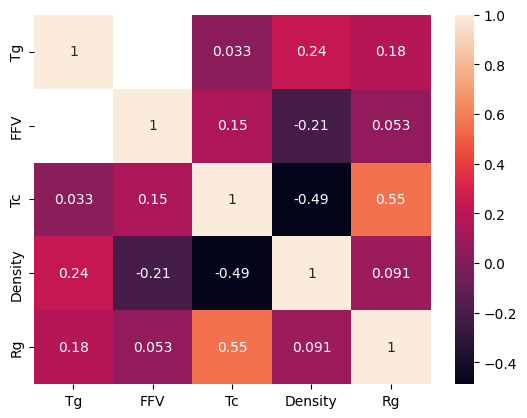

In [8]:
import seaborn as sns

#plotting the heatmap for correlation
corr_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
ax = sns.heatmap(corr_df.select_dtypes(include=np.number).drop('id', axis=1).corr(), annot=True)

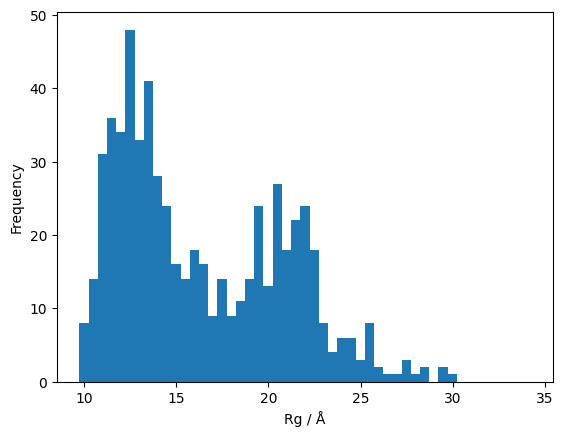

7973


In [9]:
def make_bins(items, step=1):
    items = items.dropna()
    bins = []
    i = min(items)
    while i < max(items):
        bins.append(i)
        i += step
    return bins

#Index(['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg'], dtype='object')

plt.hist(init_train_data['Rg'], bins=make_bins(init_train_data['Rg'], step=0.5), density=False)
plt.ylabel('Frequency')
plt.xlabel('Rg / Å')
plt.show()

print(len(init_train_data))

# K-Fold Cross Validation

Over 200 numeric descriptors were calculated for each polymer, based on the molecular structure of their monomers. 

K-fold cross validation is a statistical test used to ascertain the performance of a model. First, the dataset is divided into K equal subsets (or folds). Next, the model is trained on K – 1 folds and tested on the final fold. This is repeated K times, and the performance of the model is averaged across the K tests.

Using K-fold cross validation can improve the accuracy of the model’s prediction. It reduces the variance in the performance by reducing the dependence on each given train/test split and thus reduces overfitting. This provides a reliable estimate of how well the model can generalise. Furthermore, hyperparameter tuning with K-fold cross validation ensures that the hyperparameters are not selected to optimise one specific validation step.

XGBoost regression models were trained using K-fold cross validation. For each iteration, the model was trained on K – 1 folds, using the final fold for validation, and then tested on the test data. At the end, the predictions for each property were averaged across the K runs. The aim of this method was to reduce overfitting. 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.impute import SimpleImputer

targets = ['FFV', 'Tg', 'Tc', 'Rg', 'Density']
seed = 42
np.random.seed(seed)

xgb_params = {
    'n_estimators': 5000,
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'verbosity': 0,
}

pred_classes = {}

class VerboseEveryN(xgb.callback.TrainingCallback):
    def __init__(self, n):
        self.n = n
    def after_iteration(self, model, epoch, evals_log):
        if epoch % self.n == 0:
            for data_name, metrics in evals_log.items():
                for metric_name, values in metrics.items():
                    print(f"Round {epoch} - {data_name} {metric_name}: {values[-1]: .4f}")
        return False


        
for target in targets:
    print(f"\n\nCurrently working on target: {target}")
    X = train_df
    y = init_train_data[target]
    folds = 3
    kf = KFold(n_splits = folds)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    # Final ensemble prediction
    current_class_pred = np.zeros((1, len(test_df)), dtype = float)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"\n--- Fold {fold + 1} / {folds} ---")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        xgb_callbacks = [VerboseEveryN(2000)]
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(
            X_train, y_train,
            eval_set = [(X_test, y_test)],
            early_stopping_rounds = 200,
            verbose = 0,
            callbacks = xgb_callbacks
        )
        pred = model.predict(test_df)
        current_class_pred += model.predict(test_df)
    current_class_pred /= folds
    pred_classes[target] = current_class_pred



Currently working on target: FFV

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  0.0302
Round 2000 - validation_0 rmse:  0.0186
Round 4000 - validation_0 rmse:  0.0183

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  0.0295
Round 2000 - validation_0 rmse:  0.0163
Round 4000 - validation_0 rmse:  0.0159

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  0.0288
Round 2000 - validation_0 rmse:  0.0149
Round 4000 - validation_0 rmse:  0.0145


Currently working on target: Tg

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  102.0285

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  121.2319

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  109.2327


Currently working on target: Tc

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  0.0907
Round 2000 - validation_0 rmse:  0.0498
Round 4000 - validation_0 rmse:  0.0495

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  0.0862
Round 2000 - validation_0 rmse:  0.0358
Round 4000 - validation_0 rmse:  0.0353

--- Fold 3 / 3 ---
Round 0 - valid

In [11]:
def scatter_plot(pred, true, x_label=None, y_label=None, title=None):
    plt.scatter(pred, true, s=3)
    plt.plot(true, true, c='black')
    if x_label: plt.xlabel(x_label)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.show()

### Results without K-Fold Cross Validation

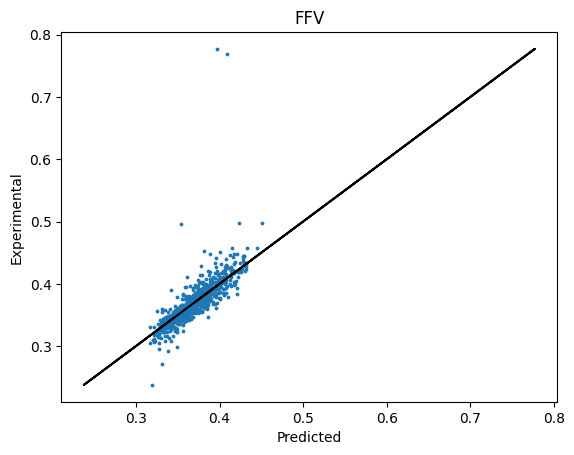

Target: FFV. Test Score: 0.5977749305113698


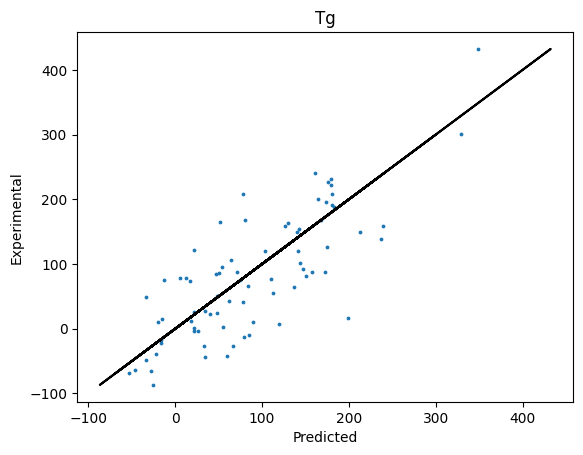

Target: Tg. Test Score: 0.6057076338232432


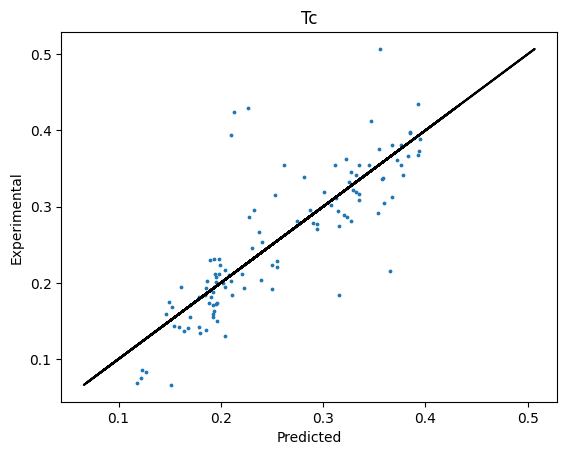

Target: Tc. Test Score: 0.6962639791798348


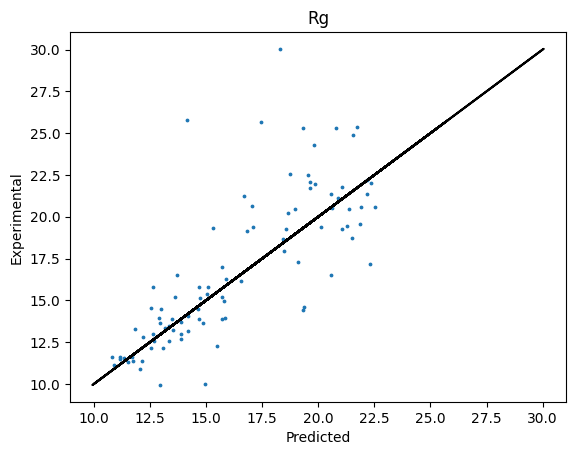

Target: Rg. Test Score: 0.5906872894273398


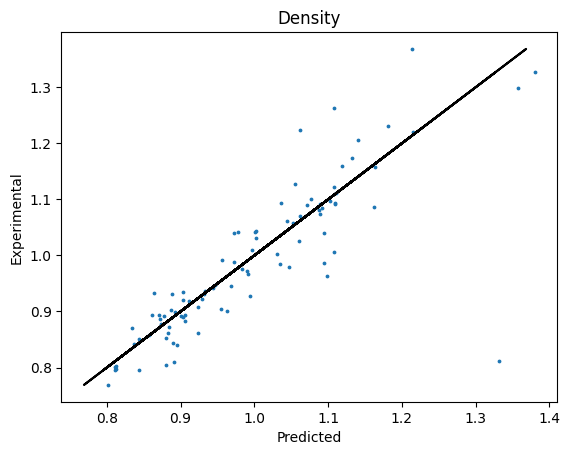

Target: Density. Test Score: 0.690498828200574


In [12]:
for target in targets:
    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 200,
        verbose = 0
    )

    pred_y = model.predict(X_test)
    scatter_plot(pred_y, y_test, x_label='Predicted', y_label='Experimental', title=target)

    print(f'Target: {target}. Test Score:', r2_score(y_test, pred_y))


### Results with K-Fold Cross Validation


--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  0.0292
Round 2000 - validation_0 rmse:  0.0149
Round 4000 - validation_0 rmse:  0.0145

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  0.0277
Round 2000 - validation_0 rmse:  0.0147
Round 4000 - validation_0 rmse:  0.0144

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  0.0299
Round 2000 - validation_0 rmse:  0.0186
Round 4000 - validation_0 rmse:  0.0183


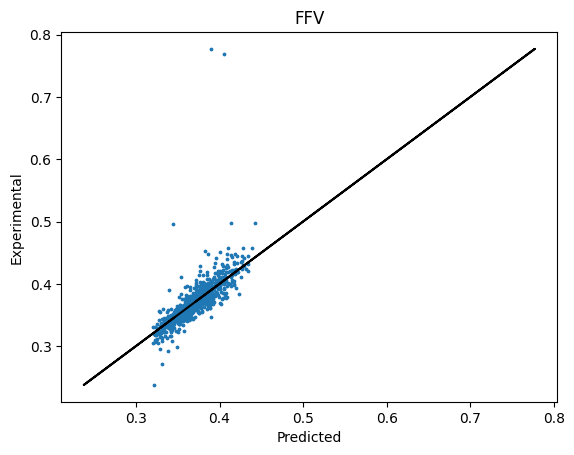

Target: FFV. Test Score: 0.5777408622264326

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  122.1485

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  113.5268

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  103.4924


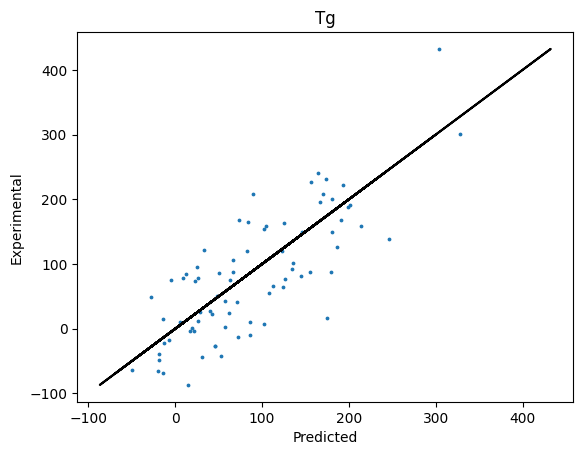

Target: Tg. Test Score: 0.6081071686897014

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  0.0886
Round 2000 - validation_0 rmse:  0.0411
Round 4000 - validation_0 rmse:  0.0406

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  0.0877

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  0.0887
Round 2000 - validation_0 rmse:  0.0447
Round 4000 - validation_0 rmse:  0.0444


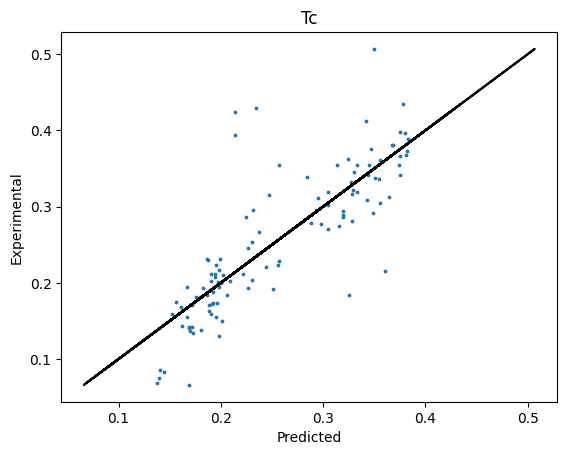

Target: Tc. Test Score: 0.6853236607103717

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  4.5563

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  4.5048

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  4.7265
Round 2000 - validation_0 rmse:  2.5855


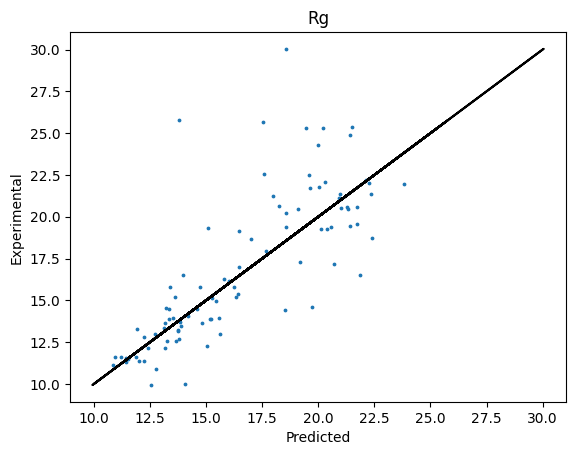

Target: Rg. Test Score: 0.6026840957926944

--- Fold 1 / 3 ---
Round 0 - validation_0 rmse:  0.1830
Round 2000 - validation_0 rmse:  0.1103
Round 4000 - validation_0 rmse:  0.1096

--- Fold 2 / 3 ---
Round 0 - validation_0 rmse:  0.1231
Round 2000 - validation_0 rmse:  0.0529
Round 4000 - validation_0 rmse:  0.0522

--- Fold 3 / 3 ---
Round 0 - validation_0 rmse:  0.1316
Round 2000 - validation_0 rmse:  0.0674
Round 4000 - validation_0 rmse:  0.0670


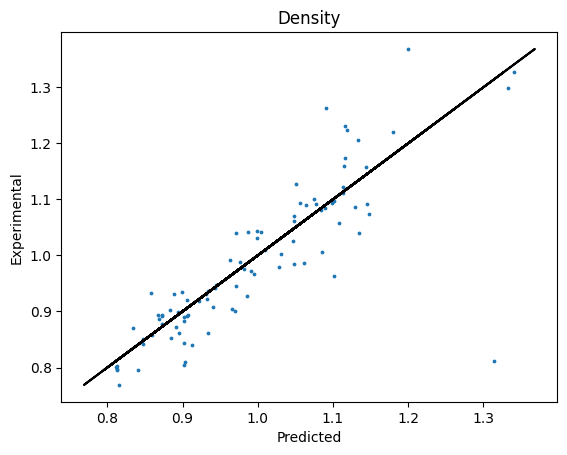

Target: Density. Test Score: 0.6891039637815142


In [13]:
for target in targets:
    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)

    # Kfolds
    folds = 3
    kf = KFold(n_splits = folds)
    
    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
    
    # Final ensemble prediction
    current_class_pred = np.zeros((1, len(X_test)), dtype = float)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t)):
        print(f"\n--- Fold {fold + 1} / {folds} ---")
        X_train, y_train = X_t.iloc[train_idx], y_t.iloc[train_idx]
        X_val, y_val = X_t.iloc[val_idx], y_t.iloc[val_idx]

        xgb_callbacks = [VerboseEveryN(2000)]
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(
            X_train, y_train,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 200,
            verbose = 0,
            callbacks = xgb_callbacks
        )
        
        current_class_pred += model.predict(X_test)

    current_class_pred /= folds

    scatter_plot(current_class_pred, y_test, 
                 x_label='Predicted', y_label='Experimental', title=target)

    print(f'Target: {target}. Test Score:', r2_score(y_test, current_class_pred.flatten()))


On the whole, the model’s predictions are improved by using K-fold cross validation. 

For most of the properties, the best predictions were achieved for K = 3. Large values of K reduce the accuracy of the results as small validation sets lead to noisy error estimates and thus produce a larger variation in the predictions across the iterations. 

In [14]:
sample = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/test.csv")

submission = pd.DataFrame({
    "id": sample['id'],
    'Tg': pred_classes['Tg'].squeeze(),
    'FFV': pred_classes['FFV'].squeeze(),
    'Tc': pred_classes['Tc'].squeeze(),
    'Density': pred_classes['Density'].squeeze(),
    'Rg': pred_classes['Rg'].squeeze()
})

In [15]:
submission.to_csv('submission.csv', index = False)

# Bagging

Bagging is an ensemble meta-algorithm designed to increase the accuracy of models by reducing variance and overfitting. It achieves this by generating N new datasets by uniformly sampling the original dataset with replacement. This ensures that each dataset is independent. N copies of the same model are then trained on each of the new datasets and their predictions are averaged to give an aggregate result.

In [16]:
from sklearn.ensemble import BaggingRegressor, VotingRegressor

bag_size = 10
print(f'Bagging {bag_size} XGB Regressors')

for target in targets:
    xgb_estimator = xgb.XGBRegressor(**xgb_params)
    bag_model = BaggingRegressor(xgb_estimator, bag_size, random_state=42)
    
    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    bag_model.fit(X_train, y_train)
    print(target, bag_model.score(X_test, y_test))


Bagging 10 XGB Regressors
FFV 0.6085190333960884
Tg 0.5804459020707533
Tc 0.6963415899714193
Rg 0.6177675117608921
Density 0.6999870121151268


In general, increasing the number of estimators increases the accuracy of the ensemble’s predictions, until it reaches a plateau. This is because bagging reduces the variance but not the bias. 

In [17]:
sample = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/test.csv")

pred_bagging = dict()

bag_size = 10
print(f'Bagging {bag_size} XGB Regressors')

for target in targets:
    print(target)
    xgb_estimator = xgb.XGBRegressor(**xgb_params)
    bag_model = BaggingRegressor(xgb_estimator, bag_size, random_state=42)
    
    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    bag_model.fit(X, y)
    pred_bagging[target] = bag_model.predict(test_df)

submission = pd.DataFrame({
    "id": sample['id'],
    'Tg': pred_bagging['Tg'].squeeze(),
    'FFV': pred_bagging['FFV'].squeeze(),
    'Tc': pred_bagging['Tc'].squeeze(),
    'Density': pred_bagging['Density'].squeeze(),
    'Rg': pred_bagging['Rg'].squeeze()
})

submission.to_csv('submission_bagging.csv', index = False)

Bagging 10 XGB Regressors
FFV
Tg
Tc
Rg
Density


# Voting

Voting is another ensemble meta-algorithm that fits a set of base models and averages their predictions to produce a final result. Unlike bagging, voting permits the use of different base models, and each model is fitted on the whole training dataset. 
Three voting ensemble models were created, as follows:

1.	Linear Regressor, Random Forest Regressor, K Neighbours Regressor, XGBoost Regressor
2.	Linear Regressor, Random Forest Regressor, K Neighbours Regressor
3.	Linear Regressor, K Neighbours Regressor, XGBoost Regressor


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

for target in targets:
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=30, random_state=42)
    r3 = KNeighborsRegressor()
    r4 = xgb.XGBRegressor(**xgb_params)

    voter = VotingRegressor([('lr', r1), ('rf', r2), ('kn', r3)])   

    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    voter.fit(X_train, y_train)
    print(target, voter.score(X_test, y_test))


FFV 0.6672161457508619
Tg 0.4558340680625358
Tc 0.6935206772155242
Rg 0.5225131354246397
Density 0.6885281710674167


Voting incorporates the benefits and drawbacks of each base model. Thus, poor performing and unsuitable models (such as the linear regressor and K neighbours regressor) can detrimentally affect the ensemble’s predictions. Here, the random forest regressor performs better by itself.

# Model Insights

SHAP values were used to uncover insights into the trained XGBoost model. 

The SHAP force plots demonstrate how each descriptor impacted the final model prediction, examples of which are given below for each property.

The most important descriptors identified by the SHAP values are difficult to interpret as they correspond to abstract chemical features of the molecules. 

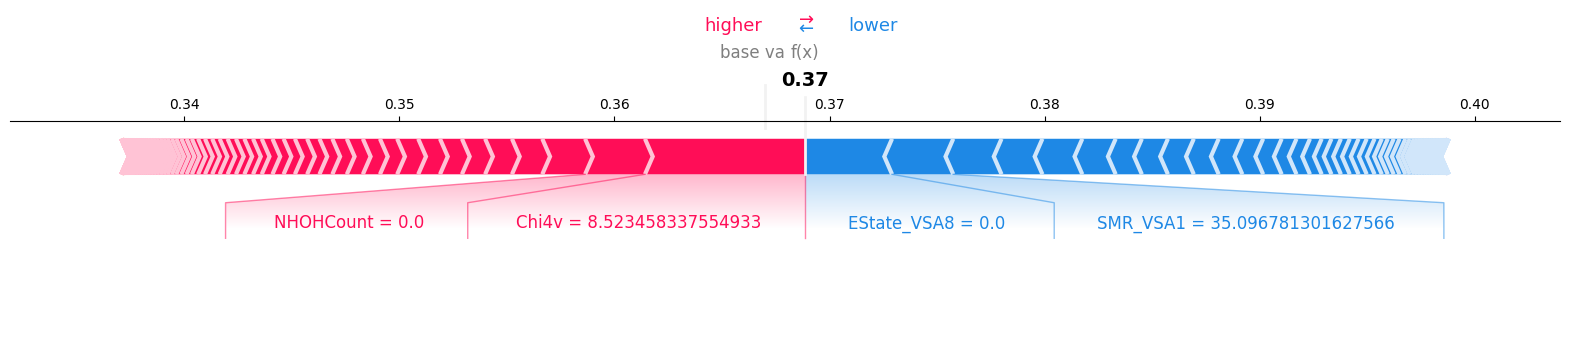

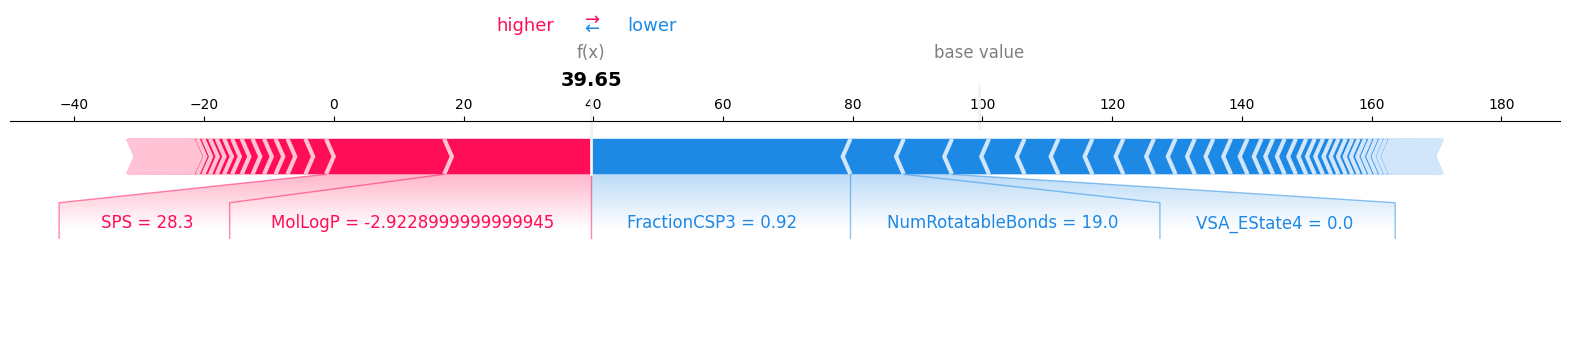

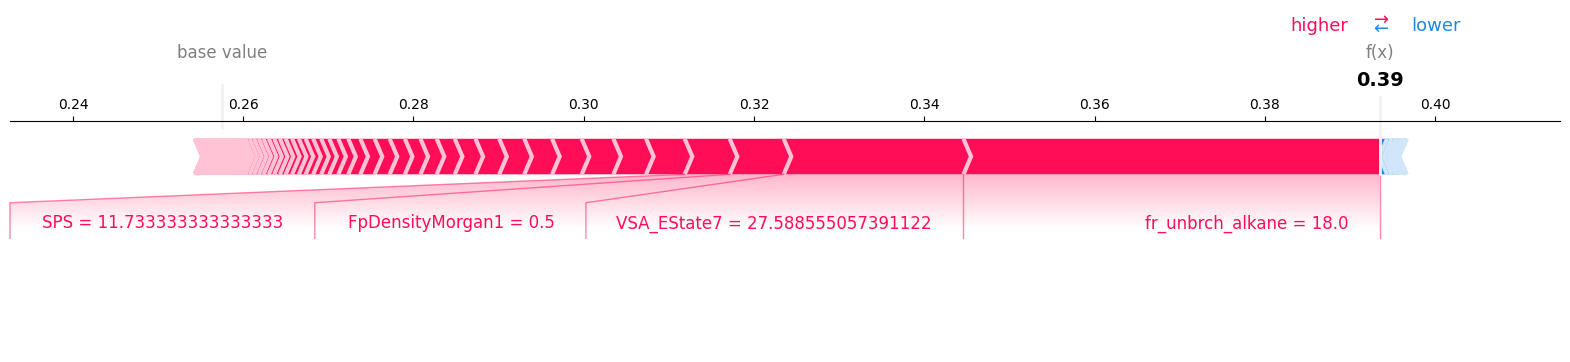

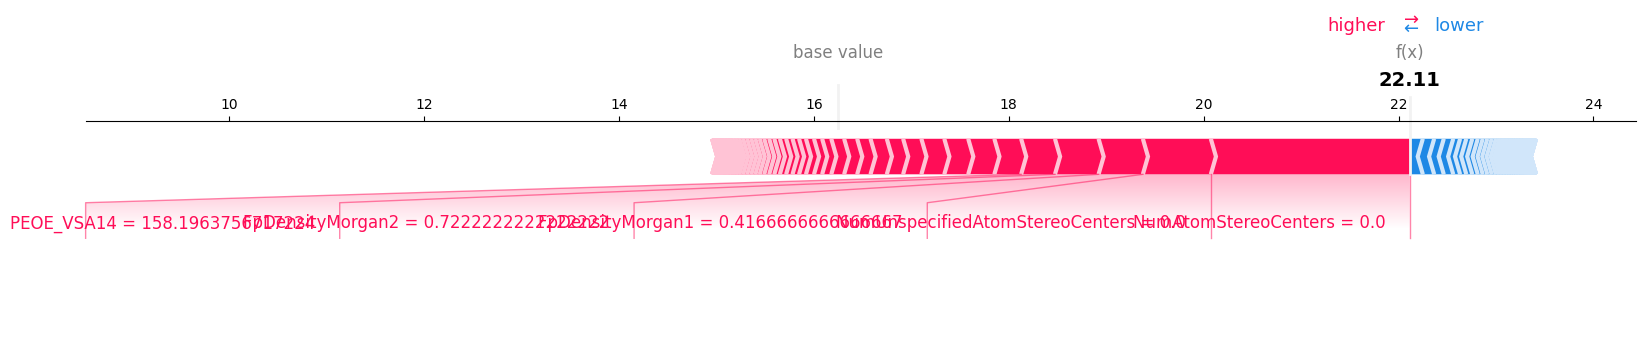

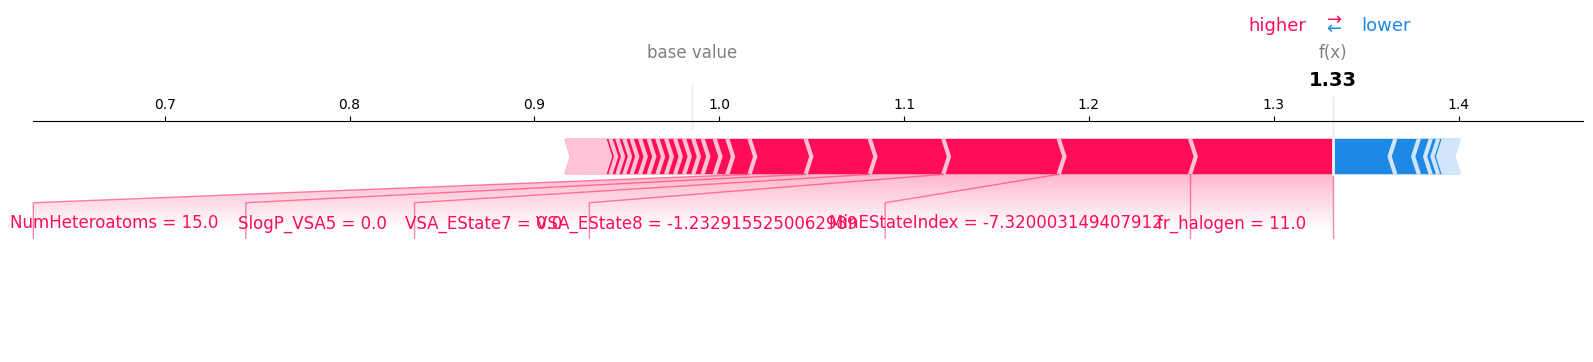

In [19]:
import shap

for target in targets:
    X = train_df
    y = init_train_data[target]
    
    # clipping data to prevent inf/missing=inf error from xgb could also do (-1e10, 1e10)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    X = X.clip(-1e6, 1e6)
    y = y.clip(-1e6, 1e6)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 200,
        verbose = 0
    )

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    print()
    shap.force_plot(explainer.expected_value, shap_values[0], X_test.values[0], feature_names = X_test.columns.tolist(), matplotlib=True)
    plt.show()

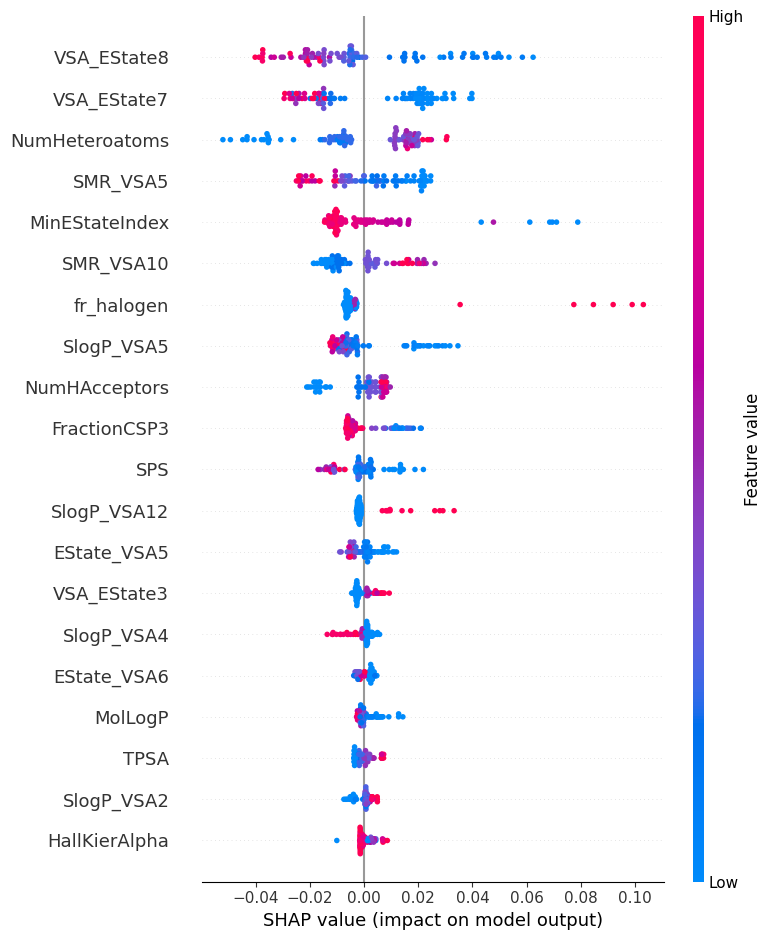

In [20]:
shap.summary_plot(shap_values, X_test)

# Conclusion 

K-fold cross validation and ensemble models can be effective at improving prediction accuracy by reducing variance and overfitting. They achieve this by aggregating the results from multiple different models, averaging their errors. 

Here, bagging produced the most accurate predictions, whilst the use of unsuitable linear regression models made voting the worst performer. 
